# Imports and Common definitions

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats
import pickle
import seaborn as sns

In [ ]:
mount_google_drive = True

In [ ]:
if mount_google_drive:
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_folder = "/content/gdrive/MyDrive/COVID19-MSC"
csvs_folder = f"{data_folder}/data"

# Functions for Analysis

In [ ]:
def unpickle(pickle_filename):
  res = None
  with open(pickle_filename, 'rb') as infile:
    res = pickle.load(infile)
  return res

In [ ]:
def numpy_corr(y_true, y_pred):
  corrs = list()
  for i in range(y_true.shape[1]):
    y_true_temp = np.squeeze(y_true[:, i])
    y_pred_temp = np.squeeze(y_pred[i])
    corrs.append(np.corrcoef([y_true_temp, y_pred_temp])[0][1])
  corrs = np.array(corrs)
  return corrs

def corr_of_vals(data):
  val_data = np.array(
      list(
          map(
              lambda _ : numpy_corr(_[1], _[2]),
              data)
          )
      )
  return val_data

def val_bce_calc(y_true, y_pred):
  bces_list = list()
  bce = lambda true, pred: -true*np.log(pred) - (1-true)*np.log(1-pred)
  for i in range(y_true.shape[1]):
    y_true_temp = np.squeeze(y_true[:, i])
    y_pred_temp = np.squeeze(y_pred[i])
    bces_list.append(bce(y_true_temp, y_pred_temp).mean())
  bces_list = np.array(bces_list)
  return bces_list

def bce_of_vals(data):
  val_data = np.array(
      list(
          map(
              lambda _: val_bce_calc(_[1], _[2]) ,#(-_[1]*np.log(_[2])-(1-_[1])*np.log(1-_[2])).mean(),
              data)
          )
      )
  return val_data


In [ ]:
def get_covid19_antibodes():
    return [
            'COV2-2050_400_escape',
            'COV2-2832_400_escape',
            'COV2-2165_400_escape',
            'COV2-2479_400_escape',
            'COV2-2096_400_escape',
            'COV2-2499_400_escape',
            'COV2-2082_400_escape',
            'COV2-2677_400_escape',
            'COV2-2094_400_escape'
            ]

#Data Analysis

## Data Visualization

In [ ]:
bind_and_antibody_df_file = f"{csvs_folder}/starr2020_binding_and_escapes.csv"
bind_and_antibody_df = pd.read_csv(bind_and_antibody_df_file)

In [ ]:
bind_and_antibody_df = bind_and_antibody_df.drop('Unnamed: 0', axis=1)

As you can see bellow - the antibody data is very skewed.

In [ ]:
bind_and_antibody_df.skew()

site                    -0.030398
bind_avg                -2.554307
expr_avg                -0.619298
COV2-2050_400_escape    10.502013
COV2-2082_400_escape    11.782447
COV2-2094_400_escape    14.172642
COV2-2096_400_escape     6.394536
COV2-2165_400_escape    14.440290
COV2-2479_400_escape    15.458416
COV2-2499_400_escape     5.215478
COV2-2677_400_escape     7.442261
COV2-2832_400_escape    10.335189
CR3022_400_escape        4.936991
dtype: float64

In [ ]:
only_antibodies = bind_and_antibody_df[
                                       [
                                        "COV2-2050_400_escape",
                                        "COV2-2082_400_escape",
                                        "COV2-2094_400_escape",
                                        "COV2-2096_400_escape",
                                        "COV2-2165_400_escape",
                                        "COV2-2479_400_escape",
                                        "COV2-2499_400_escape",
                                        "COV2-2677_400_escape",
                                        "COV2-2832_400_escape",
                                        ]
                                       ]

We suspect that multi task might help some antibodies as you can see that some do possess positive correlation with others.

In [ ]:
only_antibodies.corr()

,COV2-2050_400_escape,COV2-2082_400_escape,COV2-2094_400_escape,COV2-2096_400_escape,COV2-2165_400_escape,COV2-2479_400_escape,COV2-2499_400_escape,COV2-2677_400_escape,COV2-2832_400_escape
COV2-2050_400_escape,1.000000,-0.008296,-0.006472,0.193553,0.002644,0.727332,-0.019089,-0.010496,0.128674
COV2-2082_400_escape,-0.008296,1.000000,0.818400,-0.013384,-0.000711,0.003064,-0.011857,0.282353,-0.010874
COV2-2094_400_escape,-0.006472,0.818400,1.000000,-0.008345,-0.004256,0.007439,-0.017348,0.392172,-0.012055
COV2-2096_400_escape,0.193553,-0.013384,-0.008345,1.000000,-0.012604,0.248394,0.128220,-0.017114,-0.007156
COV2-2165_400_escape,0.002644,-0.000711,-0.004256,-0.012604,1.000000,-0.002941,-0.012502,-0.006359,0.165999
COV2-2479_400_escape,0.727332,0.003064,0.007439,0.248394,-0.002941,1.000000,-0.013114,0.007322,0.124557
COV2-2499_400_escape,-0.019089,-0.011857,-0.017348,0.128220,-0.012502,-0.013114,1.000000,-0.026269,-0.017387
COV2-2677_400_escape,-0.010496,0.282353,0.392172,-0.017114,-0.006359,0.007322,-0.026269,1.000000,-0.014940
COV2-2832_400_escape,0.128674,-0.010874,-0.012055,-0.007156,0.165999,0.124557,-0.017387,-0.014940,1.000000


Since the data is very skewed, we plot the histogram with y axis in log scale.

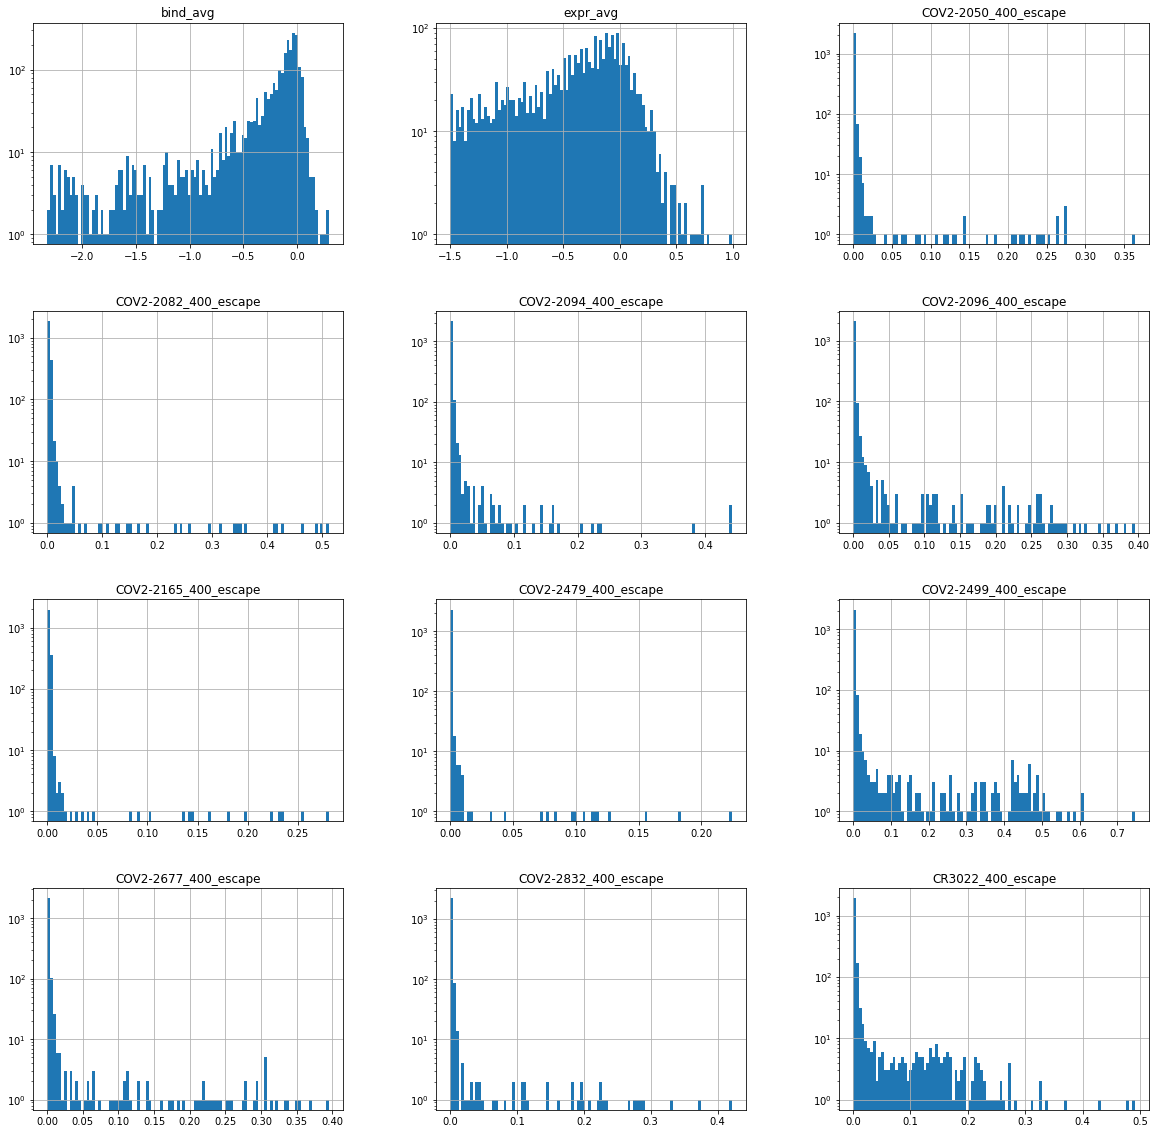

In [ ]:
bind_and_antibody_df.drop("site", axis=1).hist(figsize=(20,20), 
                                               bins=100, 
                                               log=True)
print()

In [ ]:
cols = [
        "COV2-2050_400_escape",
        "COV2-2082_400_escape",
        "COV2-2094_400_escape",
        "COV2-2096_400_escape",
        "COV2-2165_400_escape",
        "COV2-2479_400_escape",
        "COV2-2499_400_escape",
        "COV2-2677_400_escape",
        "COV2-2832_400_escape",
]
q = bind_and_antibody_df[cols].quantile(0.95)
inds = (bind_and_antibody_df[cols] > q).any(axis=1)
#inds = np.repeat(inds, 19)
inds.describe()

count      2366
unique        2
top       False
freq       1662
dtype: object

In [ ]:
bind_and_antibody_df[cols]

,COV2-2050_400_escape,COV2-2082_400_escape,COV2-2094_400_escape,COV2-2096_400_escape,COV2-2165_400_escape,COV2-2479_400_escape,COV2-2499_400_escape,COV2-2677_400_escape,COV2-2832_400_escape
0,0.000520,0.000966,0.000645,0.000430,0.000853,0.000116,0.000835,0.000677,0.000954
1,0.001027,0.003825,0.001350,0.001237,0.001763,0.000911,0.001527,0.001254,0.001804
2,0.001501,0.005344,0.001996,0.000400,0.002283,0.000786,0.001759,0.001806,0.002302
3,0.001433,0.001929,0.001778,0.001178,0.001704,0.000613,0.002303,0.001868,0.001905
4,0.001544,0.002498,0.002005,0.000745,0.001469,0.000544,0.002050,0.001913,0.001567
...,...,...,...,...,...,...,...,...,...
2361,0.002828,0.003554,0.002110,0.000663,0.001813,0.000691,0.002543,0.002898,0.002043
2362,0.001082,0.003879,0.001859,0.001385,0.001949,0.000769,0.001536,0.001430,0.002350
2363,0.000836,0.005417,0.001208,0.000585,0.002404,0.000532,0.002600,0.001354,0.002467
2364,0.002494,0.003683,0.002215,0.001027,0.002120,0.000896,0.002741,0.002042,0.002254


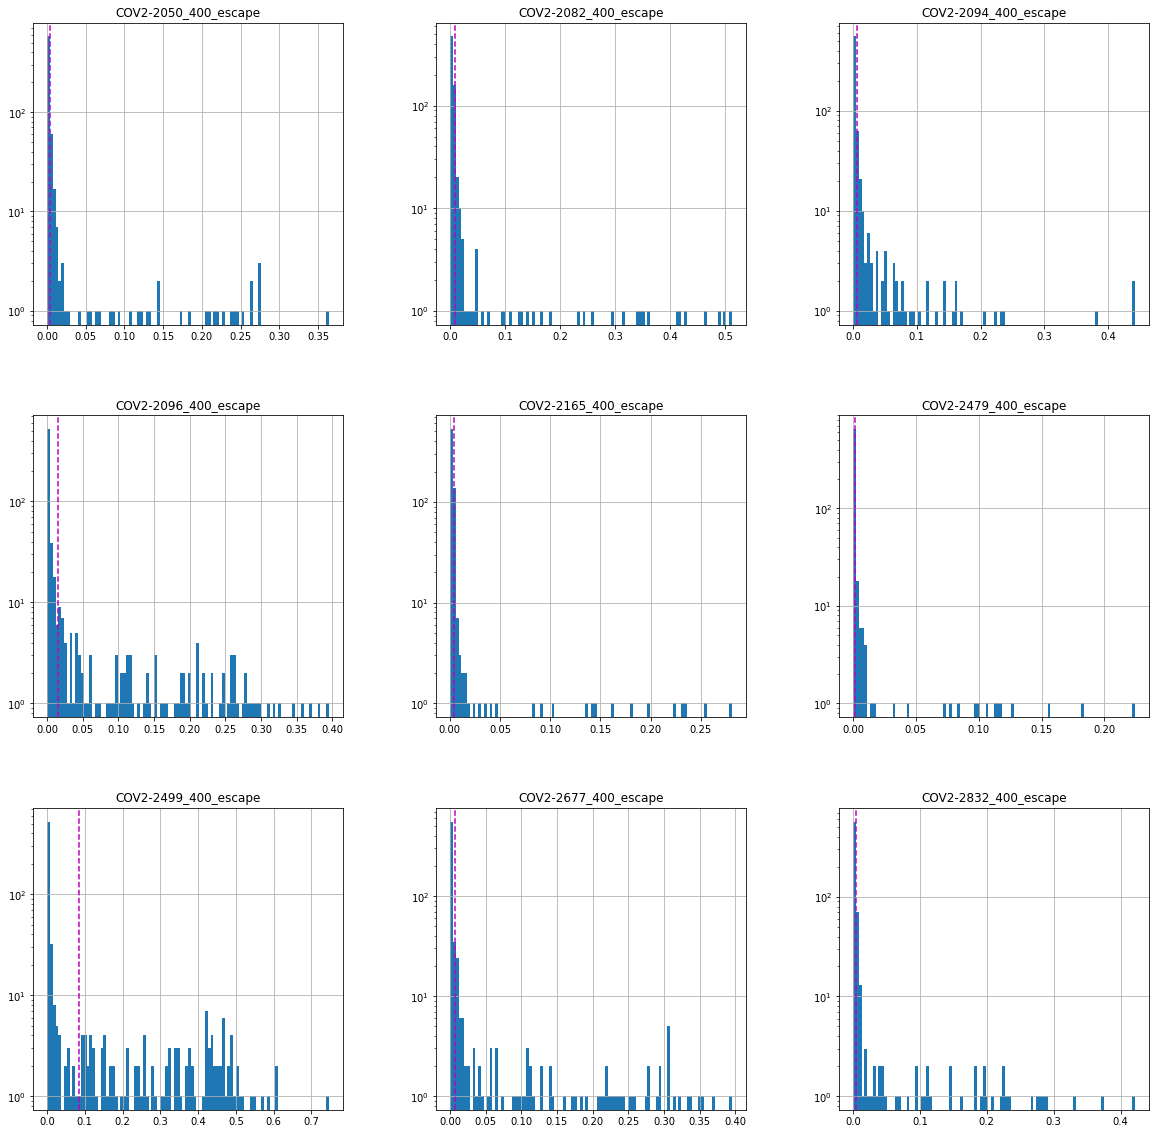

In [ ]:
f = bind_and_antibody_df[cols][inds].hist(figsize=(20,20), 
                                          bins=100,
                                          log=True)
[_.axvline(bind_and_antibody_df[col].quantile(0.95), color='m', linestyle='dashed') for _, col in zip(f.ravel(), cols)]
print()

In [ ]:
bind_and_antibody_df[cols][inds].skew()

COV2-2050_400_escape    5.567789
COV2-2082_400_escape    6.313563
COV2-2094_400_escape    7.698416
COV2-2096_400_escape    3.212646
COV2-2165_400_escape    7.800903
COV2-2479_400_escape    8.348970
COV2-2499_400_escape    2.497929
COV2-2677_400_escape    3.816134
COV2-2832_400_escape    5.486375
dtype: float64

In [ ]:
bind_and_antibody_df[cols].skew()

COV2-2050_400_escape    10.502013
COV2-2082_400_escape    11.782447
COV2-2094_400_escape    14.172642
COV2-2096_400_escape     6.394536
COV2-2165_400_escape    14.440290
COV2-2479_400_escape    15.458416
COV2-2499_400_escape     5.215478
COV2-2677_400_escape     7.442261
COV2-2832_400_escape    10.335189
dtype: float64

In [ ]:
bind_and_antibody_df[inds][cols].corr()-bind_and_antibody_df[cols].corr()

,COV2-2050_400_escape,COV2-2082_400_escape,COV2-2094_400_escape,COV2-2096_400_escape,COV2-2165_400_escape,COV2-2479_400_escape,COV2-2499_400_escape,COV2-2677_400_escape,COV2-2832_400_escape
COV2-2050_400_escape,0.000000,-0.033898,-0.036442,-0.043535,-0.027328,-0.005748,-0.065981,-0.047881,-0.032216
COV2-2082_400_escape,-0.033898,0.000000,-0.005380,-0.053477,-0.027281,-0.024523,-0.061990,-0.031273,-0.036212
COV2-2094_400_escape,-0.036442,-0.005380,0.000000,-0.057061,-0.028353,-0.025902,-0.067112,-0.028444,-0.038348
COV2-2096_400_escape,-0.043535,-0.053477,-0.057061,0.000000,-0.043346,-0.026792,-0.088777,-0.076036,-0.058831
COV2-2165_400_escape,-0.027328,-0.027281,-0.028353,-0.043346,0.000000,-0.020107,-0.050361,-0.036765,-0.024250
COV2-2479_400_escape,-0.005748,-0.024523,-0.025902,-0.026792,-0.020107,0.000000,-0.047325,-0.033818,-0.023314
COV2-2499_400_escape,-0.065981,-0.061990,-0.067112,-0.088777,-0.050361,-0.047325,0.000000,-0.089172,-0.069038
COV2-2677_400_escape,-0.047881,-0.031273,-0.028444,-0.076036,-0.036765,-0.033818,-0.089172,0.000000,-0.050430
COV2-2832_400_escape,-0.032216,-0.036212,-0.038348,-0.058831,-0.024250,-0.023314,-0.069038,-0.050430,0.000000


In [ ]:
only_antibodies.quantile([0.5, 0.75, 0.9, 0.95, 0.99])

,COV2-2050_400_escape,COV2-2082_400_escape,COV2-2094_400_escape,COV2-2096_400_escape,COV2-2165_400_escape,COV2-2479_400_escape,COV2-2499_400_escape,COV2-2677_400_escape,COV2-2832_400_escape
0.50,0.001404,0.003682,0.001921,0.000806,0.001955,0.000725,0.002216,0.001767,0.002148
0.75,0.001904,0.004903,0.002620,0.001286,0.002521,0.000927,0.003317,0.002407,0.002776
0.90,0.002726,0.006271,0.004007,0.004346,0.003119,0.001165,0.008383,0.003650,0.003640
0.95,0.003998,0.008258,0.006017,0.015166,0.003645,0.001417,0.083781,0.006798,0.004797
0.99,0.099302,0.096369,0.069407,0.251336,0.011672,0.007931,0.463715,0.236189,0.115338


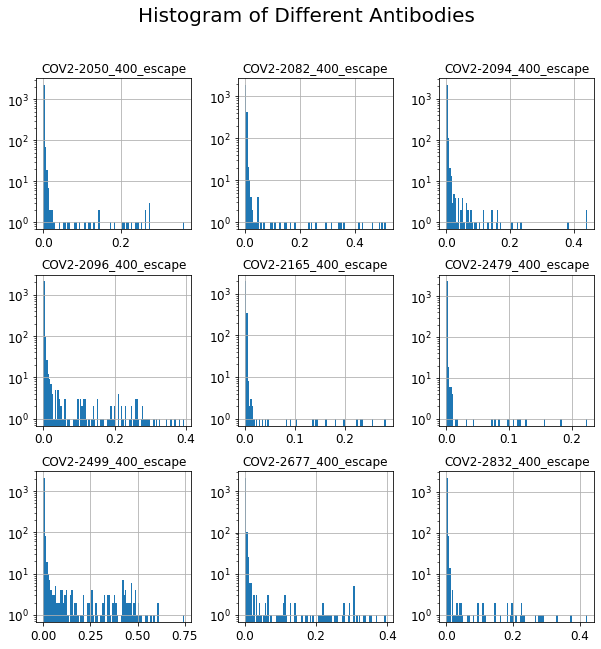

In [ ]:
f = only_antibodies.hist(figsize=(10,10), 
                         bins=100, 
                         log=True,
                         )
[_.tick_params(labelsize=12) for _ in f.ravel()]
plt.suptitle("Histogram of Different Antibodies", fontsize=20)
plt.show
pass

As you can see, all the antibodies have major jump in value from the top 5% to the top 1%.
Lets look at all rows that at least once column is in the top 1%:

In [ ]:
qunatiles_of_interest = bind_and_antibody_df[[
                                              "COV2-2050_400_escape",
                                              "COV2-2082_400_escape",      
                                              "COV2-2094_400_escape",      
                                              "COV2-2096_400_escape",      
                                              "COV2-2165_400_escape",      
                                              "COV2-2479_400_escape",      
                                              "COV2-2499_400_escape",      
                                              "COV2-2677_400_escape",      
                                              "COV2-2832_400_escape",
                                              ]
                                              ].quantile(0.99)
rows = set()
for col in qunatiles_of_interest.index:
  ind_to_add = bind_and_antibody_df[bind_and_antibody_df[col] >= qunatiles_of_interest.loc[col]].index
  rows.update(ind_to_add)
  print(f"New {len(rows)} rows in top qunatiles")
rows = sorted(rows)

New 24 rows in top qunatiles
New 48 rows in top qunatiles
New 52 rows in top qunatiles
New 74 rows in top qunatiles
New 98 rows in top qunatiles
New 107 rows in top qunatiles
New 130 rows in top qunatiles
New 146 rows in top qunatiles
New 163 rows in top qunatiles


From above we can clearly see that some new rows are added. 
From this alone one can easily assume that being in the top 1% percentile of one antibody escape doesnt mean you will be in others.
This insight is interesting because it mean that learning effect of mutations on one antibody is not enough in order to rank mutations. Furthermore it means that in order to learn all of them we may gain bio-mechanical knowledge about the process in which COVID-19 interacts with the immune system.
Now lets take some statistics on how this rows look.

In [ ]:
bind_and_antibody_df.iloc[rows].sample(10)

,site,mutation,bind_avg,expr_avg,COV2-2050_400_escape,COV2-2082_400_escape,COV2-2094_400_escape,COV2-2096_400_escape,COV2-2165_400_escape,COV2-2479_400_escape,COV2-2499_400_escape,COV2-2677_400_escape,COV2-2832_400_escape,CR3022_400_escape
1863,157,R,-2.30,-0.25,0.000290,0.000461,0.000444,0.000956,0.231500,0.000178,0.000492,0.000361,0.194600,0.000420
1838,156,G,-0.77,-0.08,0.000654,0.002341,0.000812,0.000529,0.002068,0.000528,0.001051,0.000853,0.289100,0.001618
1301,118,P,-1.65,-0.64,0.003109,0.005944,0.003965,0.265200,0.003322,0.000798,0.262300,0.003928,0.003516,0.003830
1946,166,L,-1.70,-0.17,0.004908,0.003267,0.001507,0.000801,0.001812,0.004837,0.499300,0.001479,0.005179,0.003471
1826,155,P,-1.53,-0.68,0.217400,0.005466,0.002629,0.000678,0.002582,0.127900,0.002091,0.001858,0.111800,0.005247
1042,87,Y,-0.08,0.07,0.001593,0.124000,0.045860,0.000609,0.001635,0.000830,0.002571,0.001562,0.001726,0.003532
1807,154,P,-0.28,-0.02,0.132100,0.000412,0.000403,0.018730,0.000791,0.000172,0.000325,0.000264,0.017750,0.000526
1800,154,G,-0.06,-0.42,0.122200,0.006220,0.001302,0.000497,0.002783,0.001353,0.002527,0.001214,0.002832,0.006325
1836,156,D,-1.69,0.11,0.003696,0.002567,0.001274,0.001723,0.001365,0.000694,0.002244,0.001249,0.329800,0.002508
1858,157,H,-1.87,-0.30,0.001834,0.005229,0.002711,0.000910,0.002914,0.000937,0.002903,0.002301,0.231200,0.003624


In [ ]:
bind_and_antibody_df.iloc[rows].mutation.value_counts()

K    16
R    14
Y    14
D    14
E    12
P    10
N    10
W     9
T     8
F     8
L     7
H     6
G     6
A     6
Q     5
V     5
C     4
I     4
S     3
M     2
Name: mutation, dtype: int64

In [ ]:
bind_and_antibody_df.iloc[rows].site.value_counts()

154    18
156    12
48     11
160    10
157    10
54      8
166     7
122     6
87      6
90      6
46      6
145     5
117     4
116     4
78      4
168     4
120     3
118     3
115     3
159     3
126     3
39      2
35      2
44      2
142     2
164     2
56      1
41      1
42      1
34      1
16      1
199     1
83      1
91      1
105     1
113     1
170     1
119     1
125     1
130     1
133     1
155     1
3       1
Name: site, dtype: int64

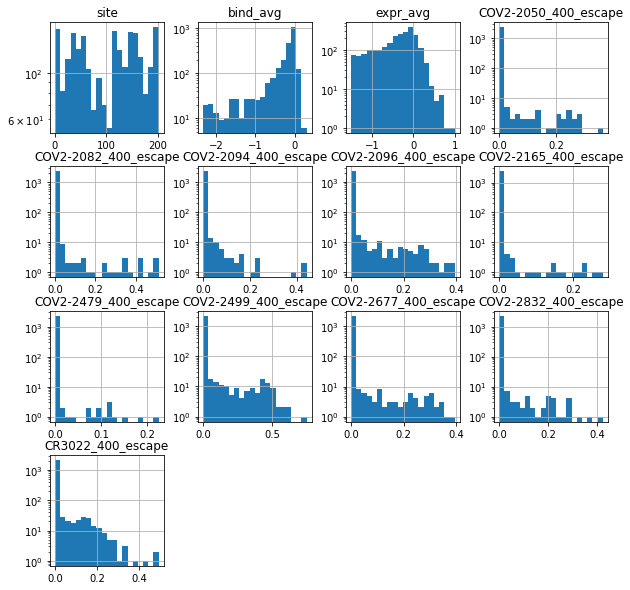

In [ ]:
bind_and_antibody_df.hist(figsize=(10,10), log=True, bins=20)
print()

Some of the data is NaN (antibodies that were not tested on some site)

In [ ]:
bind_and_antibody_df.notna().all()

site                     True
mutation                 True
bind_avg                 True
expr_avg                 True
COV2-2050_400_escape    False
COV2-2082_400_escape    False
COV2-2094_400_escape    False
COV2-2096_400_escape    False
COV2-2165_400_escape    False
COV2-2479_400_escape    False
COV2-2499_400_escape    False
COV2-2677_400_escape    False
COV2-2832_400_escape    False
CR3022_400_escape       False
dtype: bool

For the rest of this notebook we will just ignore those as they are small portion of the data (11 rows).

In [ ]:
bind_and_antibody_df[~bind_and_antibody_df.notna().all(axis=1)]

,site,mutation,bind_avg,expr_avg,COV2-2050_400_escape,COV2-2082_400_escape,COV2-2094_400_escape,COV2-2096_400_escape,COV2-2165_400_escape,COV2-2479_400_escape,COV2-2499_400_escape,COV2-2677_400_escape,COV2-2832_400_escape,CR3022_400_escape
218,17,N,-2.15,-0.60,NaN,NaN,NaN,0.246200,NaN,0.001260,NaN,NaN,NaN,0.003855
267,24,C,-0.29,-1.00,NaN,NaN,NaN,0.000871,NaN,NaN,NaN,NaN,NaN,NaN
275,24,M,-0.23,-0.91,NaN,NaN,NaN,0.001722,NaN,0.001791,NaN,NaN,NaN,0.008597
286,26,F,-0.15,-1.31,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN
355,30,P,-0.04,-1.33,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN
363,31,D,-0.86,-0.65,NaN,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN
928,75,M,-0.08,-1.01,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1206,113,D,-2.06,-1.26,NaN,0.004683,NaN,0.050500,0.004136,NaN,NaN,NaN,0.004626,NaN
1667,145,W,-2.26,-1.09,0.003642,0.005256,0.004518,0.002355,0.023210,NaN,0.005852,0.004746,0.005192,NaN
1757,151,W,-0.09,-1.05,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN


In [ ]:
bind_and_antibody_df = bind_and_antibody_df[bind_and_antibody_df.notna().all(axis=1)]

Later on we are going to augument our data by balncing between the top 5% and bottom 95%. Lets examine are both of them look. We will focus on "COV2-2050" as an example. Notice that the top 95% looks similiar to a gaussian (except the big column in the zero area).

In [ ]:
data_of_interest = bind_and_antibody_df['COV2-2050_400_escape']
top_5_quantile = data_of_interest.quantile(q=0.95)

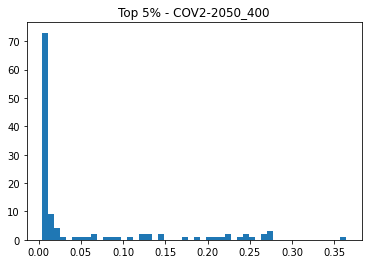

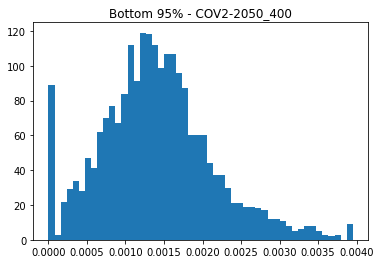

In [ ]:
plt.figure()
plt.title("Top 5% - COV2-2050_400")
plt.hist(data_of_interest[data_of_interest >=top_5_quantile], bins=50)
plt.figure()
plt.title("Bottom 95% - COV2-2050_400")
plt.hist(data_of_interest[data_of_interest < top_5_quantile], bins=50)
pass

In [ ]:
other_antibody_df_file = f"{csvs_folder}/starr_cocktails.csv"
other_antibody_df = pd.read_csv(other_antibody_df_file)

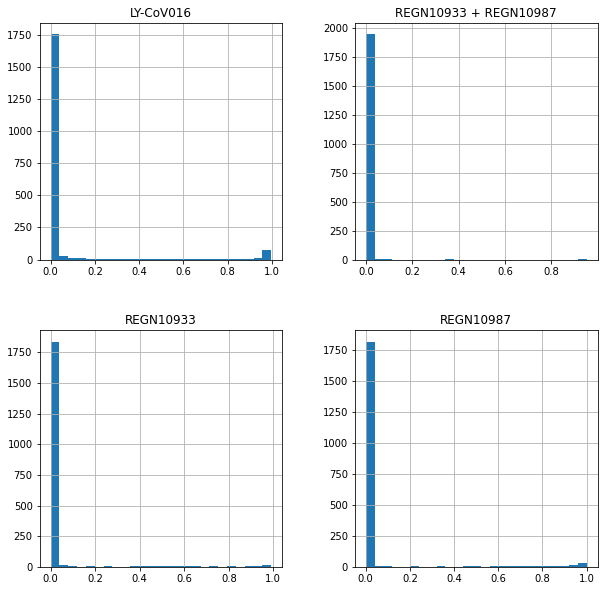

In [ ]:
cocktail_and_antibodies = [
                           'LY-CoV016',
                           'REGN10933 + REGN10987', 
                           'REGN10933', 
                           'REGN10987',
                           ]
other_antibody_df[cocktail_and_antibodies].hist(figsize=(10, 10), bins=25)
pass

In [ ]:
other_antibody_df[cocktail_and_antibodies].describe(percentiles=[i/20 for i in range(0, 20)])

,LY-CoV016,REGN10933 + REGN10987,REGN10933,REGN10987
count,1948.000000,1948.000000,1948.000000,1948.000000
mean,0.066986,0.002573,0.033845,0.050600
std,0.225167,0.023281,0.143713,0.193547
min,0.000000,0.000528,0.000000,0.001560
0%,0.000000,0.000528,0.000000,0.001560
5%,0.001093,0.001299,0.001125,0.002071
10%,0.001093,0.001392,0.001125,0.002073
15%,0.001093,0.001431,0.001125,0.002074
20%,0.001093,0.001456,0.001125,0.002075
25%,0.001093,0.001473,0.001125,0.002075


One reason we wont try to learn the cocktail is because it has very small output, you can see below that if we want to find out which amino-acid might be problem, we cant, because there are only two amino acid subtitution that have escape probability >=0.1 and only 12 (which is approximately 0.5%) with probability of >=0.02. Similiar argument can be said for several antibodies from our initial data set.

In [ ]:
cocktail = other_antibody_df["REGN10933 + REGN10987"]
cocktail_top_1_percent = cocktail.quantile(0.99)
cocktail.quantile([0.9+i/100 for i in range(0,10)]+[0.995])

0.900    0.001978
0.910    0.002034
0.920    0.002125
0.930    0.002194
0.940    0.002312
0.950    0.002468
0.960    0.002697
0.970    0.002918
0.980    0.003487
0.990    0.009981
0.995    0.025633
Name: REGN10933 + REGN10987, dtype: float64

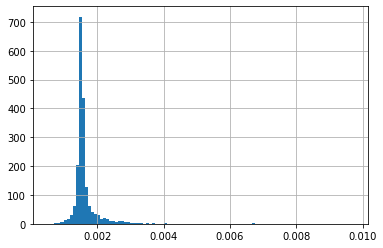

In [ ]:
cocktail[cocktail <= cocktail_top_1_percent].hist(bins=100)
pass

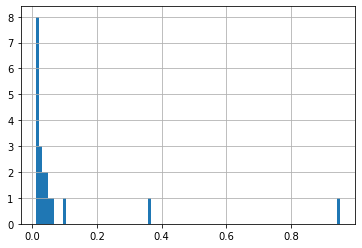

In [ ]:
cocktail[cocktail > cocktail_top_1_percent].hist(bins=100)
pass

In [ ]:
cocktail[cocktail > cocktail_top_1_percent].sort_values()

990     0.01023
1335    0.01122
1463    0.01135
949     0.01427
993     0.01519
1109    0.01728
997     0.01739
1502    0.01897
1493    0.02433
1344    0.02532
982     0.02650
983     0.03099
1516    0.03509
1097    0.04266
1112    0.04306
899     0.05335
946     0.06092
1106    0.09853
1554    0.36010
738     0.95240
Name: REGN10933 + REGN10987, dtype: float64

#Results Analysis
## Single Task VS Multi Task


We have for each antibody a prediction of our 64 layered neural networks for each train-test split including the ground truth.

The following plot shows for each antibody a boxplot of the pearson correlation between the ground truth and the neural networks predictions.
Moreover we show the results for both a single-task (trainig only on a single antibody data) with the multi-task (which trains on all antibodies in parallel) side-by-side.


**To run your own version, update the folder where the pkl:**  pkl_folder_temp 

### Classification

In [ ]:
def auc_for_res(z):
  return [metrics.roc_auc_score(z[1][:,i,0],
                                z[2][i]) for i in range(len(z[2]))]

pkl_folder_temp = [
                   '/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp14' #Put your folder
]             

antibodies = [
              "COV2-2050",
              "COV2-2832",
              "COV2-2165",
              "COV2-2479",
              "COV2-2096",
              "COV2-2499",
              "COV2-2082",
              "COV2-2677",
              "COV2-2094",
              ]
              

In [ ]:

antibodies_file_format = [
                          "no_strat_{}_bin.pkl", # Format for single task file
                          ]
print(list(enumerate(antibodies_file_format)))
label = {
    antibodies_file_format[0]: "Single-Task",
         }

antibodies_res = dict()

d_df_temp = pd.DataFrame(columns=["Antibody", "AUC", "Source"])
for file_format in label.keys():
  antibodies_no_aug_val_res = dict()
  for anti in antibodies:
    try:
      antibodies_no_aug_val_res[anti] = unpickle(f"{pkl_folder_temp[0]}/{file_format.format(anti)}")
      if 'val_data' in antibodies_no_aug_val_res[anti]:
        antibodies_no_aug_val_res[anti] = antibodies_no_aug_val_res[anti]['val_data']
      else:
        z = list(antibodies_no_aug_val_res[anti].values())[0]
        z = z['test_data']
        antibodies_no_aug_val_res[anti] = z
    except:
      print(f"cant find {pkl_folder_temp[0]}/{file_format.format(anti)}")
  antibodies_no_aug_res_corr = dict()
  for k in antibodies_no_aug_val_res.keys():
    auc_vals = list()
    auc_train = list()
    for t in antibodies_no_aug_val_res[k]:
      y_t_val, y_p_val = np.squeeze( t[1]), np.squeeze(t[2])
      auc_vals.append(metrics.roc_auc_score(y_t_val, y_p_val))
      
    antibodies_no_aug_res_corr[k] = np.array(auc_vals)

  for i in range(9):
    if antibodies[i] not in antibodies_no_aug_res_corr:
      print(f"cant {antibodies[i]}")
      continue
    d_df_temp = d_df_temp.append(
        pd.DataFrame([[_,
                      label[file_format] ,
                      antibodies[i]
                      ] for _ in   antibodies_no_aug_res_corr[antibodies[i]]],
                    columns=['AUC', 'Source', 'Antibody']))
  
multitask_files = [
                   "/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp14/multi_bin_40_dist.pkl" ,  

                 ]

for _ in enumerate(multitask_files):
  print(_)

file_to_label = {
    old_code_files[1]: "Multi Task ",
}

single_results = {
    k: unpickle(k)['val_data'] for k in file_to_label.keys()
}

single_auc = {
     k: np.array(list(map(lambda _ : auc_for_res(_),
                          v[:5])))[:,:9] for k,v in single_results.items()              
}

for k in file_to_label.keys():
  auc = single_auc[k]
  cls = [file_to_label[k]] * len(auc)
  for i in range(auc.shape[-1]):
    curr_df = pd.DataFrame.from_dict({
        'Antibody': [antibodies[i], ] * len(cls),
        'AUC': auc[:, i],
        'Source': cls,
     })
    d_df_temp = d_df_temp.append(curr_df)
covid19_selections_columns = list(range(len(set(d_df_temp.Antibody))))
plt.figure(figsize=(20, 10))
plt.title("Antibody Escape Classification", fontsize=30)
[plt.axvline(x, color = 'm', linestyle='--') for x in [i+0.5 for i, _ in enumerate(covid19_selections_columns[:-1])]]
f = sns.boxplot(x='Antibody',
                y='AUC',
                hue='Source',
                data=d_df_temp)
plt.draw()
f.set_xticklabels(f.get_xticklabels(), fontsize=18)
f.set_yticklabels(f.get_yticklabels(), fontsize=18)
f.set_ylabel("AUC", fontsize=24)
f.set_xlabel("Antibody Name", fontsize=24)
f.legend(loc='upper right', fontsize='x-large', bbox_to_anchor=(1.22, 1))

### Regression

In [ ]:
pkl_folder_temp = [
                   '/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp5/single_continuous_01_no_aug.pkl',
                   '/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp5/single_continuous_01_oversample.pkl',
                   '/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp5/multi_cont_40_dist.pkl',
                   ]
file_to_label = {
    pkl_folder_temp[0]: "Single",
    pkl_folder_temp[1]: "Multi"
}
d = dict()

for f in pkl_folder_temp :
  print(f"Start {f}")
  d[f] = np.array([numnum_cont__(z) for z in unpickle(f)])
  print("_"*20)

d_df_temp = pd.DataFrame(columns=["antibody", "correlation", "Classifier"])
for f in pkl_folder_temp:
  corr = d[f]
  cls = [file_to_label[f]] * len(corr)#["/".join(f.split("/")[-2:]) for _ in auc]
  for i in range(corr.shape[-1]):
    #print(i)
    #print(corr.shape, len(antibodies))
    curr_df = pd.DataFrame.from_dict({
        'antibody': [antibodies[i], ] * len(cls),
        'correlation': corr[:, i],
        'Classifier': cls,
    })
    d_df_temp = d_df_temp.append(curr_df)
  

In [ ]:
covid19_selections_columns = list(range(9))
plt.figure(figsize=(20, 10))
plt.title("Continuous Single-Task: Pearson Correlation", fontsize=30)
[plt.axvline(x, color = 'm', linestyle='--') for x in [i+0.5 for i, _ in enumerate(covid19_selections_columns[:-1])]]
f = sns.boxplot(x='antibody',
                y='correlation',
                hue='Classifier',
                data=d_df_temp)

plt.draw()
f.set_xticklabels(f.get_xticklabels(), fontsize=18)
f.set_yticklabels(f.get_yticklabels(), fontsize=18)

f.set_ylabel("Correlation", fontsize=24)
f.set_xlabel("Antibody Name", fontsize=24)
f.legend(loc='upper right', fontsize='x-large', bbox_to_anchor=(1.22, 1))

print()

###Results

## Analysis of the embedding

We sample a neural network from one of the multi-task neural nework and use the last layer as an embedder. In this section we will analyze performance of neural networks trained on different tasks with the new representation.

### Binding Info

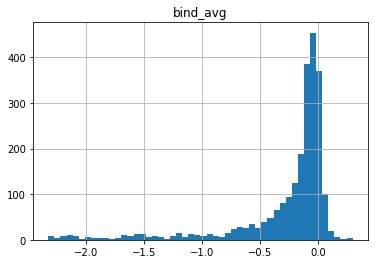

In [ ]:
bind_and_antibody_df[["bind_avg"]].hist(bins=50)
pass

Notice that bind has not strong correlation with any of the antibodies, which might be concerning. The strongest ones are negativle correlations with *COV2-2499* and *COV2-2832*.

Taking that into accound - pearson correlation cannot analyze how combination of different antibodies might interact with binding.

In [ ]:
bind_and_antibody_df.drop("site", axis=1).corr()[["bind_avg"]]

,bind_avg
bind_avg,1.000000
expr_avg,0.210459
COV2-2050_400_escape,-0.106178
COV2-2082_400_escape,-0.018187
COV2-2094_400_escape,0.000452
COV2-2096_400_escape,-0.071211
COV2-2165_400_escape,-0.164603
COV2-2479_400_escape,-0.038244
COV2-2499_400_escape,-0.389288
COV2-2677_400_escape,0.013943


### Analysis of embedding for binding + otehr antibodies

Load where the models are saved

In [ ]:
folder = r"/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp12/new/"
models = [keras.models.load_model(f"{folder}model_{_}") for _ in range(10)]
embedders_models = [keras.Model(inputs=_.input, outputs=_.get_layer(name="1_th_dense").output) for _ in models]

Load needed dataframes for train. Fix if needed.

In [ ]:
bind_and_antibody_df_file = "/content/gdrive/MyDrive/COVID19-MSC/data/starr2020_binding_and_escapes.csv"
bind_and_antibody_df = pd.read_csv(bind_and_antibody_df_file)
other_antibody_df_file = r"/content/gdrive/MyDrive/COVID19-MSC/data/starr_cocktails.csv"
other_antibody_df = pd.read_csv(other_antibody_df_file)

Files for binding

In [ ]:
bind_and_antibody_df_file = "/content/gdrive/MyDrive/COVID19-MSC/data/starr2020_binding_and_escapes.csv"
bind_and_antibody_df = pd.read_csv(bind_and_antibody_df_file)
cols = ['site', 'mutation', 'bind_avg',
        'COV2-2050_400_escape', 'COV2-2082_400_escape', 'COV2-2094_400_escape', 
        'COV2-2096_400_escape', 'COV2-2165_400_escape', 'COV2-2479_400_escape',
       'COV2-2499_400_escape', 'COV2-2677_400_escape', 'COV2-2832_400_escape',
        ]

mutation_binds2 = bind_and_antibody_df[cols]
mutation_binds2["seq"] = ""
for i in range(len(mutation_binds2)):
  mut_seq = cov2_seq[330:531]
  site = mutation_binds2.loc[i,"site"]
  mutation = mutation_binds2.loc[i,"mutation"]
  mutation_binds2.loc[i, "seq"] = mut_seq[:site-1]+mutation+mut_seq[site:]
mutation_binds = mutation_binds2[["site", "mutation", "bind_avg","seq"]]

Helpful functions

In [ ]:
def get_vocab():
    amino_acids = ['A', 'C', 'D', 'E', 'F',
                   'G', 'H', 'I', 'K', 'L',
                   'M', 'N', 'P', 'Q', 'R',
                   'S', 'T', 'V', 'W', 'Y'
                  ]
    vocabulary = { aa: idx  for idx, aa in enumerate(sorted(amino_acids)) }
    return vocabulary
    
def _featurize(orig_seq):
      vocabulary = get_vocab()
      seq = np.array([vocabulary[word] for word in orig_seq])
      return seq


Actual training

In [ ]:
r = list()
x_s = np.array(list(map(_featurize, mutation_binds.seq)))
y_s = mutation_binds.bind_avg.to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(x_s,
                                                                    y_s)
for _ in range(100):
  x_s = np.array(list(map(_featurize, mutation_binds.seq)))
  y_s = mutation_binds.bind_avg.to_numpy().reshape(-1, 1)
  X_train, X_test, y_train, y_test = model_selection.train_test_split(x_s,
                                                                      y_s)
  seq_input = keras.Input(shape=(201, ))
  embed_seq = keras.layers.Embedding(input_dim=len(get_vocab()),#+1, 
                                    output_dim=40, 
                                    name='embed_mutation',
                                    input_length=201)(seq_input)
  embed_seq = keras.layers.Flatten()(embed_seq)
  dense = keras.layers.Dense(64, activation='relu')(embed_seq)
  output= keras.layers.Dense(1)(dense)

  m = keras.Model(inputs=seq_input,
                  outputs=output)
  m.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
            loss="mean_squared_error")
  print("+", _, "+")
  m.fit(x=X_train, y=y_train,
        batch_size=64,
        validation_data=(X_test, y_test),
        epochs=100,
        verbose=0,
        callbacks=keras.callbacks.EarlyStopping(patience=3,
                                                restore_best_weights=True),
        )
  r.append((X_test, y_test, m.predict(X_test)))

with open("./binding_nn.pkl",  "wb") as fh:
  pickle.dump(r, fh)



In [ ]:
trees_binding2 = list()
for i in range(100):
  x_s = np.array(list(map(_featurize, mutation_binds.seq)))
  y_s = mutation_binds.bind_avg.to_numpy()
  X_train, X_test, y_train, y_test = model_selection.train_test_split(x_s,
                                                                      y_s)
  X_train_curr_summed = list()
  X_test_curr_summed = list()
  for embedder in embedders_models:
    X_train_curr = embedder.predict(np.array(X_train))
    X_test_curr = embedder.predict(np.array(X_test))
    
    X_train_curr_summed.append(X_train_curr)
    X_test_curr_summed.append(X_test_curr)
  
  X_train_curr_summed = sum(X_train_curr_summed)/len(X_train_curr_summed)
  X_test_curr_summed = sum(X_test_curr_summed)/len(X_test_curr_summed)

  reg = LinearRegression()
  reg.fit(X_train_curr, y_train)
  trees_binding2.append((X_test, y_test, reg.predict(X_test_curr)))

with open("/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp12/new/for_roded/binding_regression_with_embeddings.pkl",  "wb") as fh:
  pickle.dump(trees_binding2, fh)

In [ ]:
trees_cocktail2 = list()
for i in range(100):
  cols = ['LY-CoV016', 'REGN10933', 'REGN10987']
  x_s = np.array(list(map(_featurize, other_antibody_df.mutated_seq)))
  y_s = other_antibody_df[cols].to_numpy()
  X_train, X_test, y_train, y_test = model_selection.train_test_split(x_s,
                                                                      y_s)
  X_train_summed = list()
  X_test_summed = list()
  for embedder in embedders_models:#[:5]:
    X_train_curr = embedder.predict(np.array(X_train))
    X_test_curr = embedder.predict(np.array(X_test))
    X_train_summed.append(X_train_curr)
    X_test_summed.append(X_test_curr)
  X_train_curr = sum(X_train_summed)/len(X_train_summed)
  X_test_curr = sum(X_test_summed)/len(X_test_summed)
  res = list()
  for i in range(3):
    reg = LinearRegression()
    reg.fit(X_train_curr,
            y_train[:, i])
    res.append((X_test, y_test[:, i], reg.predict(X_test_curr)))
  trees_cocktail2.append(res)
with open("./other_antibodies_linear_regression.pkl",  "wb") as fh:
  pickle.dump(r, fh)

In [ ]:
r = list()
cols = ['LY-CoV016', 'REGN10933', 'REGN10987']

x_s = np.array(list(map(_featurize, other_antibody_df.mutated_seq)))
y_s = other_antibody_df[cols].to_numpy().reshape(-1, 3)
final_res = list()
for _ in range(100):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(x_s,
                                                                      y_s)
  res = list()
  for i in range(3):
    seq_input = keras.Input(shape=(201, ))
    embed_seq = keras.layers.Embedding(input_dim=len(get_vocab()),#+1, 
                                      output_dim=40, 
                                      name='embed_mutation',
                                      input_length=201)(seq_input)
    embed_seq = keras.layers.Flatten()(embed_seq)
    dense = keras.layers.Dense(64,
                               activation='relu',
                               )(embed_seq)
    output= keras.layers.Dense(1,
                               activation="sigmoid"
                               )(dense)
    m = keras.Model(inputs=seq_input,
                    outputs=output)
    m.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy")
    m.fit(X_train, 
          y_train[:, i],
          epochs=100,
          validation_data=(X_test, y_test[:, i]),
          verbose=1)
    res.append((X_test, y_test[:, i], m.predict(X_test)))
  final_res.append(res)
with open("/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp12/new/other_antibodies_nn.pkl",  "wb") as fh:
  pickle.dump(final_res, fh)


In [ ]:
other_antibodies_files = [
                          "other_antibodies_nn.pkl",
                          "other_antibodies_linear_regression.pkl"
                          ]
unpickled_bind_files = [
                        "binding_nn.pkl",
                        "binding_regression_with_embeddings"
]                          
antibodies_files = [f"/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp12/new/{_}" for _ in other_antibodies_files]
unpickled_antibodies_files = [unpickle(_) for _ in antibodies_files]

single_task = [ list(map(lambda _: np.corrcoef(_[i][1], _[i][2].squeeze())[0,1], unpickled_antibodies_files[0])) for i in range(3)]
binding_nn_no_embed = np.array(list(map(lambda _: np.corrcoef(_[1].squeeze(), _[2].squeeze())[0, 1], unpickled_bind_files[0])))

cocktails_regression = [ list(map(lambda _: np.corrcoef(_[i][1], _[i][2])[0,1], unpickled_antibodies_files[1])) for i in range(3)]
binding_reg_with_embed = np.array(list(map(lambda _: np.corrcoef(_[1].squeeze(), _[2].squeeze())[0, 1], unpickled_bind_files[1])))


In [ ]:
df = pd.DataFrame(columns=["Source", "Correlation", "Task"])
single_task_data = np.dstack([np.dstack(single_task), binding_nn_no_embed.reshape(1, -1)])
embeding_task_data = np.dstack([np.dstack(cocktails_regression), 
                                binding_reg_with_embed.reshape(1, -1),]
                               )
df["Source"] = ["Single-Task"] *len(single_task_data.flatten()) + \
               ["Regression With Embedding"] * len(embeding_task_data.flatten()) 

antibodies = ['LY-CoV016', 'REGN10933', 'REGN10987', "Binding"]
df["Task"] = antibodies*(len(df["Source"])//len(antibodies))
df["Correlation"] = list(single_task_data.flatten()) + \
                    list(embeding_task_data.flatten())

df = df[df.Source.isin(["Single-Task", "Regression With Embedding"])]


plt.figure(figsize=(20, 10))

plt.title("Assesing Embedding On Different Tasks", fontsize=30)
f = sns.boxplot(y='Correlation',
                x='Task',
                hue="Source",
                data=df)
f.set_ylabel("Source", fontsize=24)
f.set_xlabel("Task", fontsize=24)

f.legend(loc='upper right',
         fontsize='x-large', 
         bbox_to_anchor=(1, 1)
         )
f.get_figure().savefig("/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp12/new/embedding-analysis.jpeg", dpi=300)

### Variants

In [ ]:
m = unpickle("/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp12/new/multi_cont_40_dist.pkl")

In [ ]:
antibodies = [
              "COV2-2050",
              "COV2-2832",
              "COV2-2165",
              "COV2-2479",
              "COV2-2096",
              "COV2-2499",
              "COV2-2082",
              "COV2-2677",
              "COV2-2094",
              ]

multi_variants_escapes = m['variants_escapes'].squeeze()
variants_cols = ["Alpha",
                 "Alpha+E484K",
                 "Beta",
                 "Gamma",
                 "Delta",
                 "Delta Plus",
                 "Omicron",
                 ]
                 
multi_variants_escapes_df = pd.DataFrame(columns = ["Variant",
                                                    "Antibody",
                                                    "Escape"])
for i, variant in enumerate(variants_cols):
  for j, anti in enumerate(antibodies):
    curr_df =  pd.DataFrame.from_dict({
        "Variant":[variant, ]*len(multi_variants_escapes),
        "Antibody":[anti, ]*len(multi_variants_escapes),
        "Escape": multi_variants_escapes[:, j, i],
    })
    multi_variants_escapes_df = multi_variants_escapes_df.append(curr_df)

In [ ]:
plt.figure(figsize=(20, 10))
display_df = multi_variants_escapes_df[(multi_variants_escapes_df.Variant != "Alpha+E484K") &
                                       (multi_variants_escapes_df.Variant != "Delta Plus")] 
f = sns.boxplot(x='Antibody',
                y='Escape',
                hue='Variant',
                data=display_df,
                )
[plt.axvline(x, color = 'm', linestyle='--') for x in [i+0.5 for i, _ in enumerate(covid19_selections_columns[:-1])]]
f.set_xticklabels(f.get_xticklabels(), fontsize=18)
ylabels = [round(_, 4) for _ in plt.yticks()[0]]
f.set_yticklabels(ylabels, fontsize=18)
f.set_ylabel("Escape Prob", fontsize=24)
f.set_xlabel("Antibody Name", fontsize=24)
f.legend(loc='upper right', fontsize='x-large', bbox_to_anchor=(1.22, 1))
plt.draw()
f.get_figure().savefig("/content/gdrive/MyDrive/COVID19-MSC/new_code_data/temp12/new/variants-analysis.jpeg", dpi=300)